In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import joblib
import ast

In [2]:
df = pd.read_csv('../data/final_dataset.csv', dtype=np.float32)
df.describe()

,date,open,high,low,close,volume
count,74456.000000,74456.000000,74456.000000,74456.000000,74456.000000,7.445600e+04
mean,1551.727539,17561.365234,17645.437500,17472.281250,17562.277344,1.350327e+06
std,895.626648,17444.687500,17530.435547,17353.238281,17445.542969,2.814597e+06
min,1.000000,0.000000,243.600006,0.000000,243.600006,0.000000e+00
25%,776.000000,3893.802551,3909.609924,3879.997498,3893.919983,1.060162e+05
50%,1552.000000,9674.774902,9720.584961,9626.750000,9675.180176,4.637802e+05
75%,2327.000000,28517.881836,28623.537109,28411.072754,28521.245117,1.442926e+06
max,3103.000000,73612.773438,73797.679688,73260.343750,73612.773438,1.039629e+08


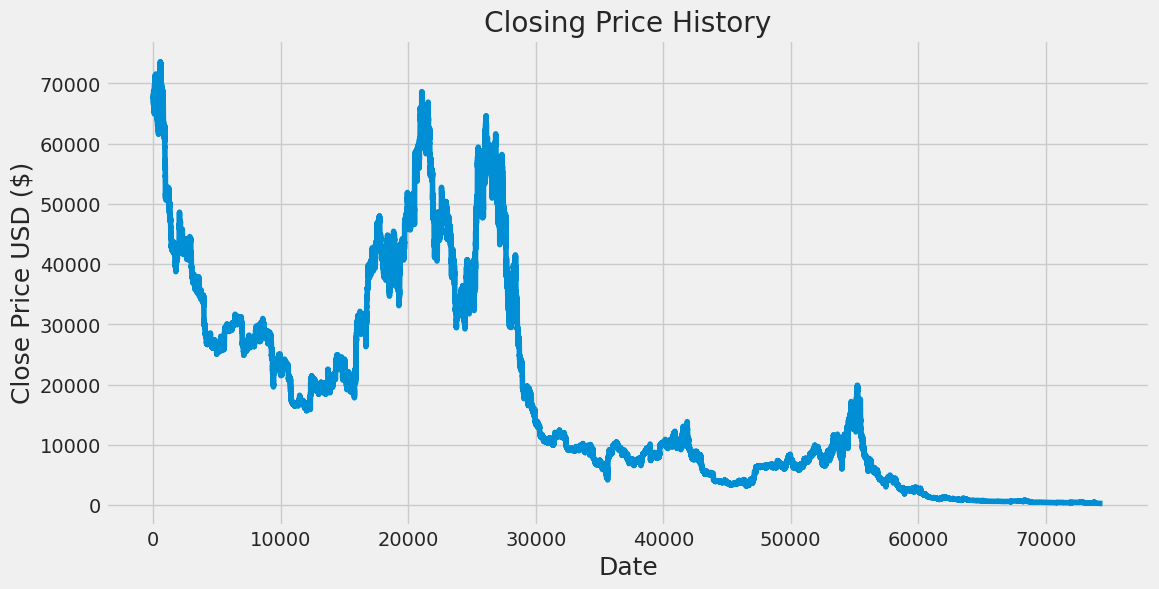

In [3]:
# Historical view of closing price
plt.figure(figsize=(12, 6))
plt.title('Closing Price History')
plt.plot(df['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

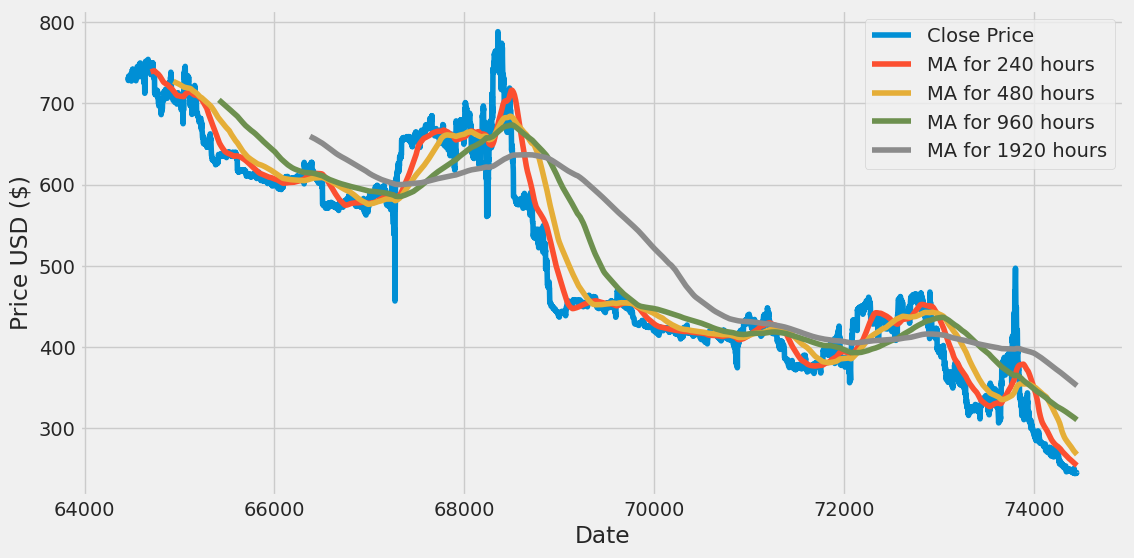

In [4]:
# Assuming df is your DataFrame containing Bitcoin price data
latest_entries_df = df.iloc[-10000:]

# Moving averages for 10 day, 20 days, 40 days, 80 days
ma_day = [240, 480, 960, 1920]
moving_averages = {}  # Dictionary to store moving averages

# Calculate moving averages
for ma in ma_day:
    column_name = f"MA for {ma} hours"
    moving_averages[column_name] = latest_entries_df['close'].rolling(window=ma).mean()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(latest_entries_df['close'], label='Close Price')

# Plotting moving averages
for ma, ma_values in moving_averages.items():
    ax.plot(ma_values, label=ma)

ax.set_xlabel('Date')
ax.set_ylabel('Price USD ($)')
ax.legend()
plt.show()


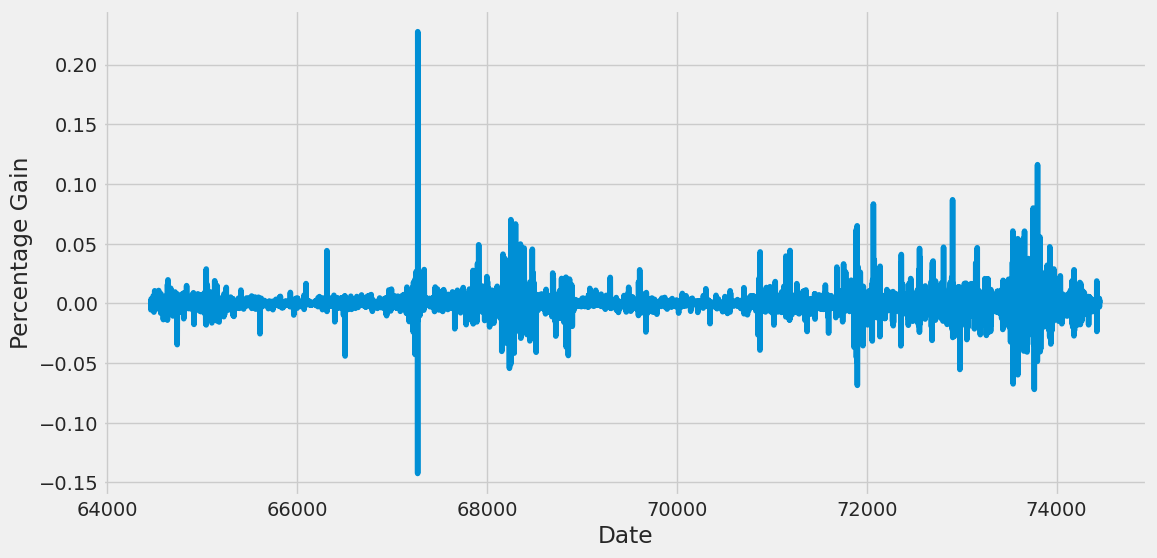

In [5]:
# Find percentage gains for each day
# Each day has the same date number
daily_return = latest_entries_df['close'] / latest_entries_df['close'].shift(1) - 1
daily_return = daily_return[1:]  # Remove first entry as it is NaN

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_return)
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Gain')
plt.show()

## Predictions

In [17]:
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # Input features
        y.append(data[i+seq_length, -1])     # Target (close price)
    return np.array(X), np.array(y)

features = ['open', 'high', 'low', 'volume']
target = 'close'

data = df[features + [target]].values

# Scale the input features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(data[:, :-1])

# Scale the target variable
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(data[:, -1].reshape(-1, 1)).flatten()

# Save the scalers for future use
joblib.dump(scaler_X, "scaler_X.save")
joblib.dump(scaler_y, "scaler_y.save")

SEQUENCE_LENGTH = 24

# Create sequences
X, y = create_sequences(np.column_stack((X_scaled, y_scaled)), SEQUENCE_LENGTH)

# Split the data sequentially
split_index = int(len(X) * 0.8)  # 80-20 split
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

training_data_len = len(X_train)

print(X_train.shape, y_train.shape)

(74456, 4)
(59545, 24, 4) (59545,)


In [7]:
# Model 1: Simple LSTM model
# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Save model
model.save('lstm_model_1.keras')

2024-04-07 05:09:54.451755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 05:09:54.452463: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
1861/1861 [==============================] - 19s 9ms/step - loss: 1.6624e-04 - val_loss: 1.6235e-06
Epoch 2/10
1861/1861 [==============================] - 15s 8ms/step - loss: 1.7122e-05 - val_loss: 6.8279e-07
Epoch 3/10
1861/1861 [==============================] - 15s 8ms/step - loss: 1.1544e-05 - val_loss: 2.2182e-08
Epoch 4/10
1861/1861 [==============================] - 15s 8ms/step - loss: 6.7263e-06 - val_loss: 7.5624e-08
Epoch 5/10
1861/1861 [==============================] - 15s 8ms/step - loss: 3.6972e-06 - val_loss: 1.2022e-07
Epoch 6/10
1861/1861 [==============================] - 15s 8ms/step - loss: 1.7396e-06 - val_loss: 1.2423e-07
Epoch 7/10
1861/1861 [==============================] - 15s 8ms/step - loss: 1.3477e-06 - val_loss: 1.1772e-08
Epoch 8/10
1861/1861 [==============================] - 14s 8ms/step - loss: 9.3885e-07 - val_loss: 1.6080e-07
Epoch 9/10
1861/1861 [==============================] - 14s 8ms/step - loss: 1.0136e-06 - val_loss: 3.9011e-07
E

In [ ]:
# Model 2: LSTM

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import regularizers

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Build the powerful LSTM model
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(LSTM(128, return_sequences=False))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Add L2 regularization
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with TensorBoard callback
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[tensorboard_callback])

# Save the model
model.save('lstm_model_2.keras')

466/466 [==============================] - 1s 3ms/step - loss: 5.9282e-08
Test Loss: 5.928158941514994e-08
466/466 [==============================] - 1s 3ms/step
Mean Absolute Error: 17.411453
Mean Squared Error: 319.1149
Root Mean Squared Error: 17.863787


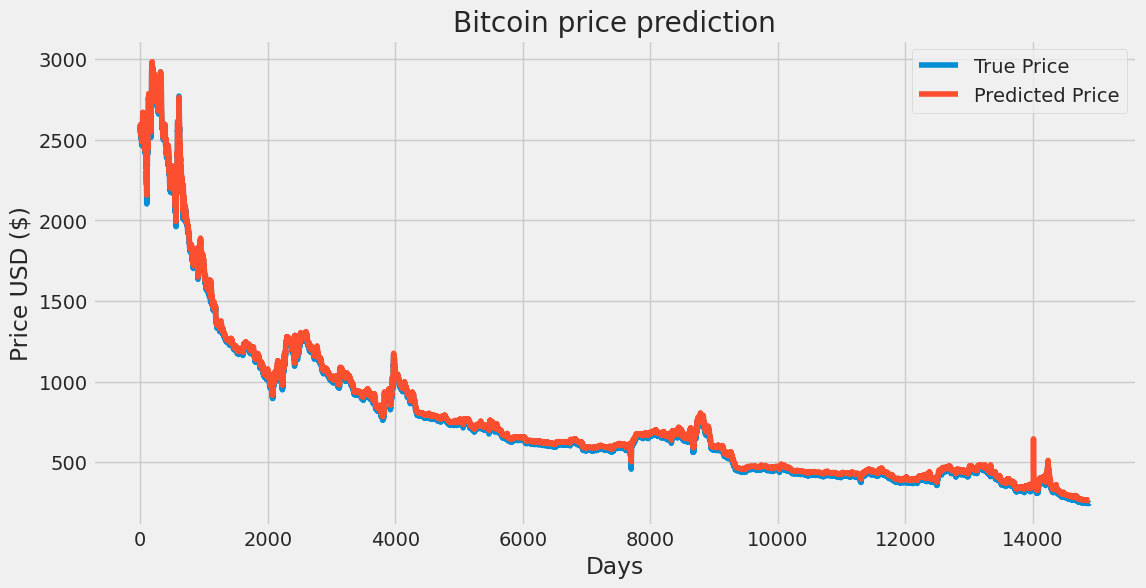

In [10]:
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

# Make predictions
test_predictions = model.predict(X_test)

# Inverse scaling
test_predictions = scaler_y.inverse_transform(test_predictions).flatten()
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Price')
plt.plot(test_predictions, label='Predicted Price')
plt.title('Bitcoin price prediction')
plt.xlabel('Days')
plt.ylabel('Price USD ($)')
plt.legend()
plt.show()

## Load and Use the model

In [38]:
# Load the keras model and scaler
from keras.models import load_model

model_loaded = load_model('lstm_model_1.keras')
scaler_X_loaded = joblib.load('scaler_X.save')
scaler_y_loaded = joblib.load('scaler_y.save')

(24, 4)
1/1 [==============================] - 0s 53ms/step


/home/rubensas/UM/tinc-buddy/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 16ms/step
           close
0   68315.804688
1   68315.804688
2   68315.804688
3   68315.804688
4   68315.804688
5   68315.804688
6   68315.804688
7   68315.804688
8   68315.804688
9   68315.804688
10  68315.804688
11  68315.804688
12  68315.804688
13  68315.804688
14  68315.804688
15  68315.804688
16  68315.804688
17  68315.804688
18  68315.804688
19  68315.804688
20  68315.804688
21  68315.804688
22  68315.804688
23  68315.804688


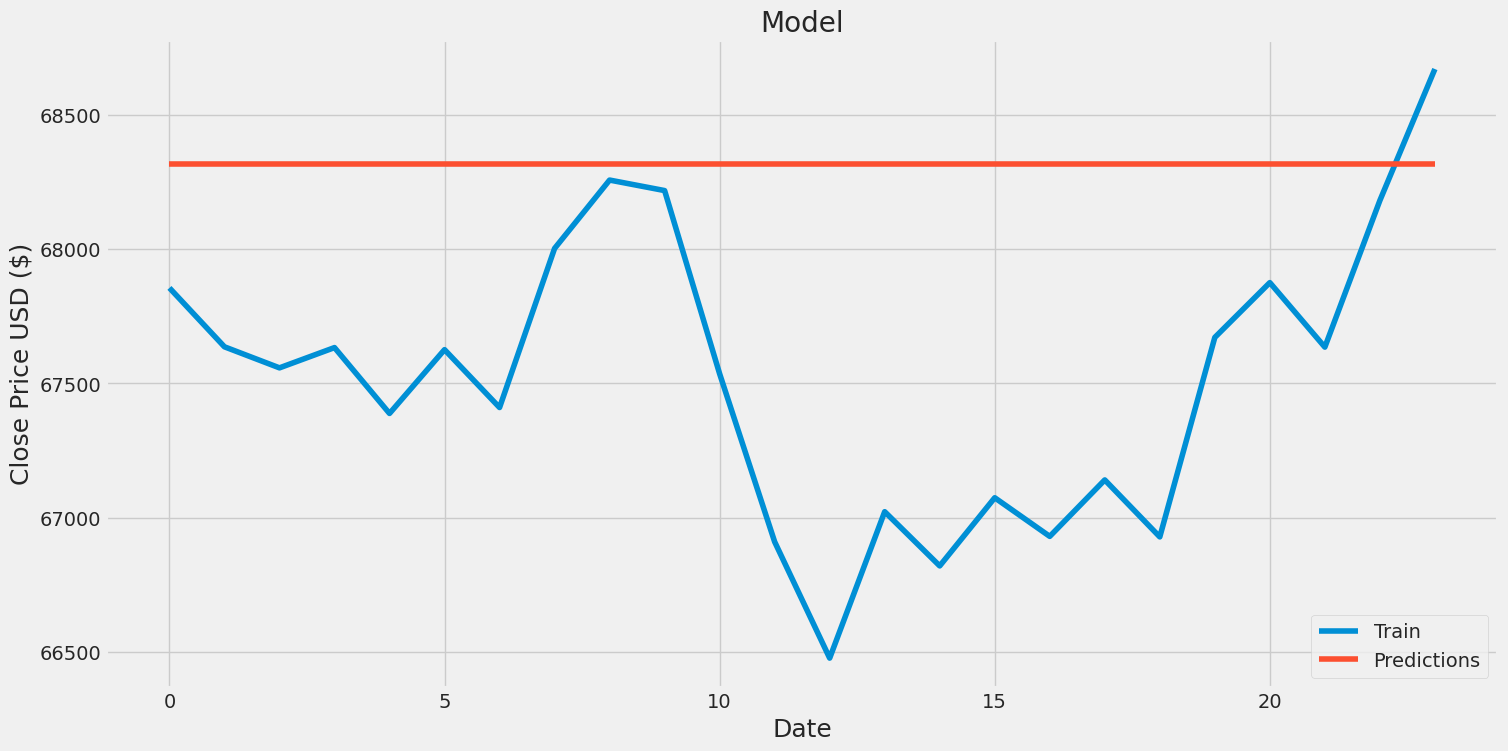

In [37]:
# Load the first 24 rows and convert the string to a DataFrame
first_vals = pd.read_csv('first_vals.csv', dtype=np.float32)
first_vals_no_close = first_vals.drop(columns=['close'])

# Scale the input features
print(first_vals_no_close.shape)
first_vals_scaled = scaler_X_loaded.transform(first_vals_no_close)

# Let's make 24 predictions
daily_predictions = []
for i in range(24):
    prediction = model_loaded.predict(np.array([first_vals_scaled]))
    daily_predictions.append(prediction[0][0])

# Inverse scaling
all_predictions = np.array(daily_predictions).reshape(-1, 1)  # Reshape to a single column
all_predictions = scaler_y_loaded.inverse_transform(all_predictions)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(all_predictions, columns=['close'])
print(predictions_df)

# Show the predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(first_vals['close'])
plt.plot(predictions_df['close'])
plt.legend(['Train', 'Predictions'], loc='lower right')
plt.show()

(24, 4)
1/1 [==============================] - 0s 22ms/step
Prediction 1: 0.9278039336204529


/home/rubensas/UM/tinc-buddy/.venv/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
Prediction 2: 0.9373806715011597
1/1 [==============================] - 0s 19ms/step
Prediction 3: 0.9375646114349365
1/1 [==============================] - 0s 18ms/step
Prediction 4: 0.9375684261322021
1/1 [==============================] - 0s 20ms/step
Prediction 5: 0.9375683665275574
1/1 [==============================] - 0s 20ms/step
Prediction 6: 0.9375683665275574
1/1 [==============================] - 0s 20ms/step
Prediction 7: 0.9375683665275574
1/1 [==============================] - 0s 27ms/step
Prediction 8: 0.9375683665275574
1/1 [==============================] - 0s 17ms/step
Prediction 9: 0.9375683665275574
1/1 [==============================] - 0s 19ms/step
Prediction 10: 0.9375683665275574
1/1 [==============================] - 0s 18ms/step
Prediction 11: 0.9375683665275574
1/1 [==============================] - 0s 17ms/step
Prediction 12: 0.9375683665275574
1/1 [==============================] - 0s 20ms/step
Prediction

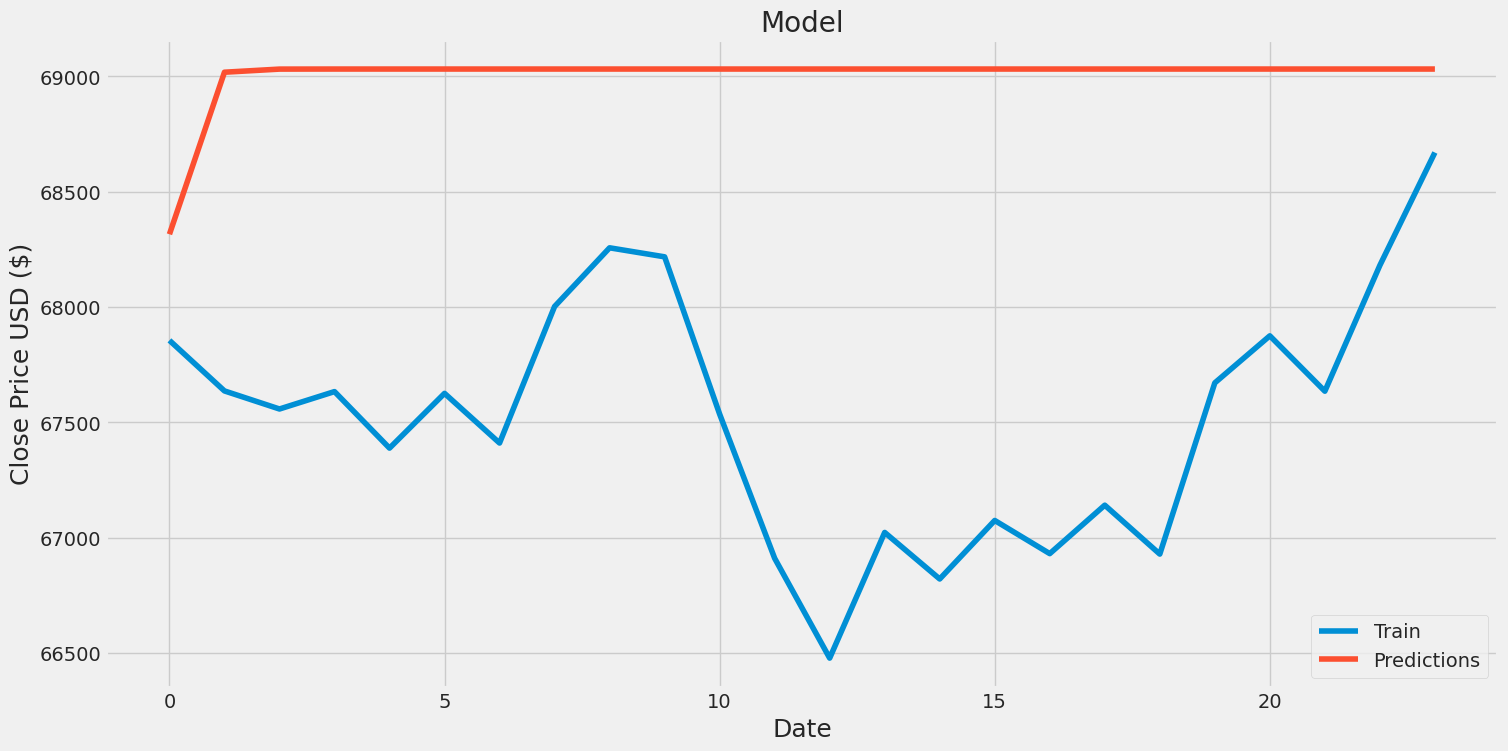

In [36]:
# Let's now predict but in each iteration add the previous prediction to the input
#
# Load the first 24 rows and convert the string to a DataFrame
first_vals = pd.read_csv('first_vals.csv', dtype=np.float32)
first_vals_no_close = first_vals.drop(columns=['close'])

# Scale the input features
print(first_vals_no_close.shape)
first_vals_scaled = scaler_X_loaded.transform(first_vals_no_close)

# Let's make 24 predictions
daily_predictions = []
for i in range(24):
    prediction = model_loaded.predict(np.array([first_vals_scaled]))
    daily_predictions.append(prediction[0][0])
    print(f"Prediction {i+1}: {prediction[0][0]}")
    
    # Add the prediction to the input
    first_vals_scaled[-1, -1] = prediction[-1][0]

# Inverse scaling
all_predictions = np.array(daily_predictions).reshape(-1, 1)  # Reshape to a single column
all_predictions = scaler_y_loaded.inverse_transform(all_predictions)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame(all_predictions, columns=['close'])
print(predictions_df)

# Show the predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(first_vals['close'])
plt.plot(predictions_df['close'])
plt.legend(['Train', 'Predictions'], loc='lower right')
plt.show()